# FPP multi objective optimization

### Import packages

In [1]:
#@time using WarmupFUSE
@time using FUSE
using Plots;
gr();
FUSE.logging(Logging.Info; actors = Logging.Error);

 56.980205 seconds (115.33 M allocations: 7.373 GiB, 5.50% gc time, 28.23% compilation time: 38% of which was recompilation)


### Define a working folder

In [2]:
save_folder = "opt_FPP_Solovev_Kr"

"opt_FPP_Solovev_Kr"

### Setup distributed computing environment

In [3]:
old_dir = pwd()
mkpath(save_folder)
try
    cd(save_folder) # this is to save temporary distributed files in working folder
    FUSE.parallel_environment("omega", 128 * 2) 
finally
    cd(old_dir)
end
display(pwd())
using Distributed
#@everywhere import WarmupFUSE
@everywhere import FUSE

connecting to worker 1 out of 256
connecting to worker 2 out of 256
connecting to worker 3 out of 256
connecting to worker 4 out of 256
connecting to worker 5 out of 256
connecting to worker 6 out of 256
connecting to worker 7 out of 256
connecting to worker 8 out of 256
connecting to worker 9 out of 256
connecting to worker 10 out of 256
connecting to worker 11 out of 256
connecting to worker 12 out of 256
connecting to worker 13 out of 256
connecting to worker 14 out of 256
connecting to worker 15 out of 256
connecting to worker 16 out of 256
connecting to worker 17 out of 256
connecting to worker 18 out of 256
connecting to worker 19 out of 256
connecting to worker 20 out of 256
connecting to worker 21 out of 256
connecting to worker 22 out of 256
connecting to worker 23 out of 256
connecting to worker 24 out of 256
connecting to worker 25 out of 256
connecting to worker 26 out of 256
connecting to worker 27 out of 256
connecting to worker 28 out of 256
connecting to worker 29 out o

"/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt"

### Get `ini` and `act` for FPP case and custmize as needed

In [4]:
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

In [5]:
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 2.15
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0

ini.build.plasma_gap = 0.2
ini.build.layers[:hfs_vacuum_vessel] += ini.build.layers[:hfs_vacuum_vessel_wall_inner] + ini.build.layers[:hfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
ini.build.layers[:lfs_vacuum_vessel] += ini.build.layers[:lfs_vacuum_vessel_wall_inner] + ini.build.layers[:lfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 1/0.825
ini.core_profiles.ne_ped = 1.0e20
ini.core_profiles.greenwald_fraction_ped = missing
ini.core_profiles.helium_fraction = 0.04

ini.equilibrium.boundary_from = :scalars
ini.equilibrium.xpoints = :lower
ini.build.divertors = :lower
ini.equilibrium.field_null_surface = 0.5

ini.ec_launchers.power_launched = 67.2e6

ini.pf_active.n_coils_outside = 8

ini.gasc.filename = missing
ini.gasc.case = missing

missing

In [6]:
act.ActorEquilibrium.model = :Solovev
act.ActorEquilibrium.symmetrize = false
act.ActorCHEASE.free_boundary = false
act.ActorCXbuild.rebuild_wall = true

act.ActorHFSsizing.do_plot = false
act.ActorHFSsizing.verbose = false
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.aspect_ratio_tolerance = 0.0

act.ActorEquilibriumTransport.max_iter = 8
act.ActorEquilibriumTransport.convergence_error = 5e-2
act.ActorEquilibriumTransport.do_plot = false
act.ActorTauenn.transport_model = :ds03
act.ActorTauenn.confinement_factor = 0.90
act.ActorTauenn.T_shaping = 2.5
act.ActorTauenn.temp_pedestal_ratio = 0.825
act.ActorTauenn.error = 1e-3
act.ActorTauenn.eped_only_powerlaw = true # more reliable for broader exploration

act.ActorPFcoilsOpt.do_plot = false
act.ActorPFcoilsOpt.symmetric = true
act.ActorPFcoilsOpt.update_equilibrium = false
act.ActorPFcoilsOpt.optimization_scheme = :none

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :Sheffield

:Sheffield

### Define optimization variables and ranges

In [7]:
# nominal value and ranges
ini.ec_launchers.power_launched = ini.ec_launchers.power_launched[1] ↔ [1e6, 200e6];
ini.core_profiles.zeff = ini.core_profiles.zeff ↔ [1.1, 2.5]
ini.core_profiles.greenwald_fraction = ini.core_profiles.greenwald_fraction ↔ [0.8, 1.3]
ini.core_profiles.ne_ped = ini.core_profiles.ne_ped ↔ [0.5,2.0e20]
ini.equilibrium.B0 = ini.equilibrium.B0 ↔ [1.0, 20.0]
ini.equilibrium.ip = ini.equilibrium.ip ↔ [1.0e6, 22e6]
ini.equilibrium.R0 = ini.equilibrium.R0 ↔ [3.0, 10.0];
ini.requirements.log10_flattop_duration = log10(3600.0) ↔ [log10(3600.0), log10(1000.0 * 3600.0)];


### As a good practice, test the actor/workflow that you want to optimize

In [8]:
dd = FUSE.init(ini, act);
FUSE.ActorWholeFacility(dd, act);

GEOMETRY                         EQUILIBRIUM                      TEMPERATURES                     DENSITIES                        
─────────────────────────────    ─────────────────────────────    ─────────────────────────────    ─────────────────────────────    
R0 → 4.82 [m]                    B0 → 4.71 [T]                    Te0 → 24.1 [keV]                 ne0 → 2.13e+20 [m⁻³]             
a → 1.38 [m]                     ip → 8 [MA]                      Ti0 → 19.9 [keV]                 ne_ped → 1e+20 [m⁻³]             
1/ϵ → 3.5 [m]                    q95 → 5.02                       <Te> → 10.5 [keV]                <ne> → 1.44e+20 [m⁻³]            
κ → 2.15                         βpol → 2.99                      <Ti> → 8.69 [keV]                ne0/<ne> → 1.48                  
δ → 0.7                          βtor → 0.0685                    Te0/<Te> → 2.29                  fGW → 1.26                       
ζ → -0.0505                      βn → 5.56                        Ti0

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start    R_end      material      area       volume     
     │ String  String      String    Float64    Float64    Float64    String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            0.509612    0.0        0.509612                 6.27695     10.0494
   2 │ in                  oh        0.370554    0.509612   0.880166  ReBCO          4.56415     19.9276
   3 │ in                            0.0667644   0.880166   0.94693                  0.822345     4.72025
   4 │ hfs                 tf        0.522406    0.94693    1.46934   ReBCO         16.6925     154.107
   5 │ hfs                           0.0667644   1.46934    1.5361                   2.95017    106.122
   6 │ hfs     low temp    shield    0.41092     1.5361     1.94702   Steel         11.6885     342.944
   7 │ hfs                          

​


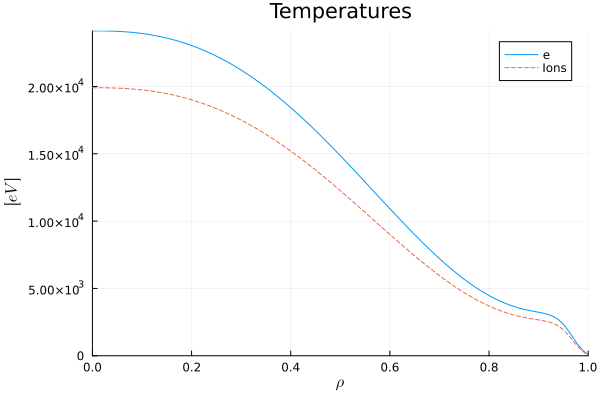

​


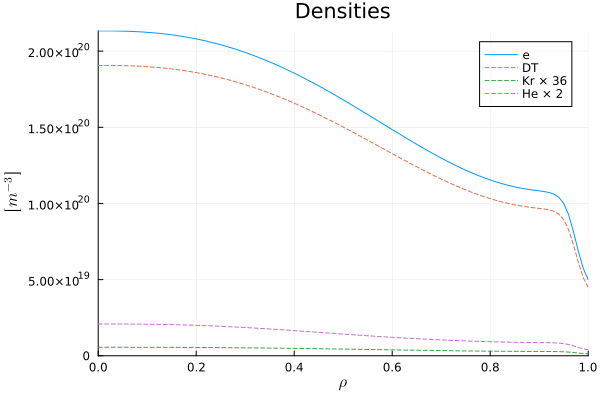

​


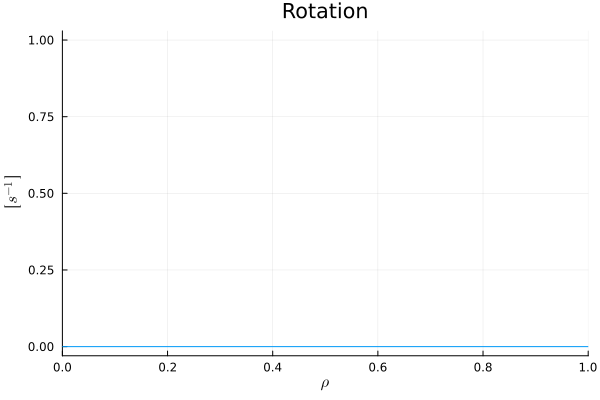

​


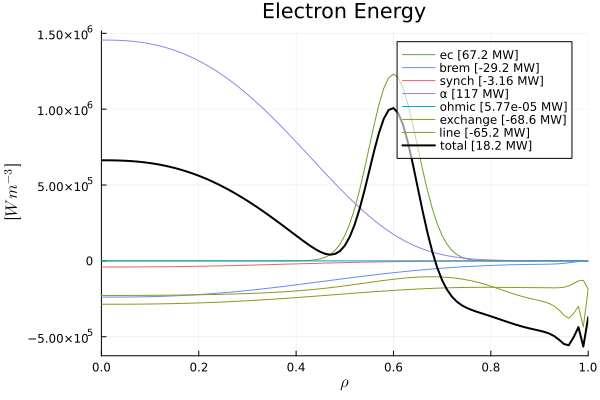

​


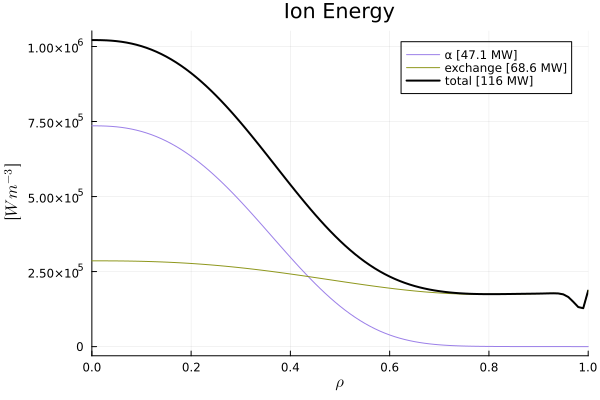

​


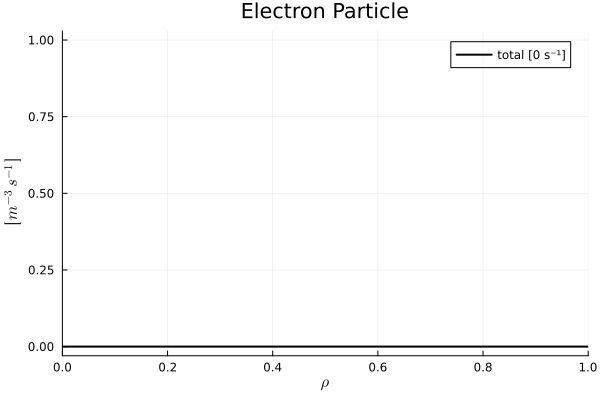

​


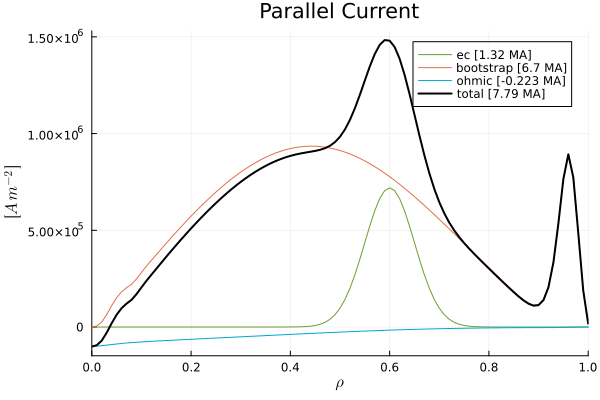

​


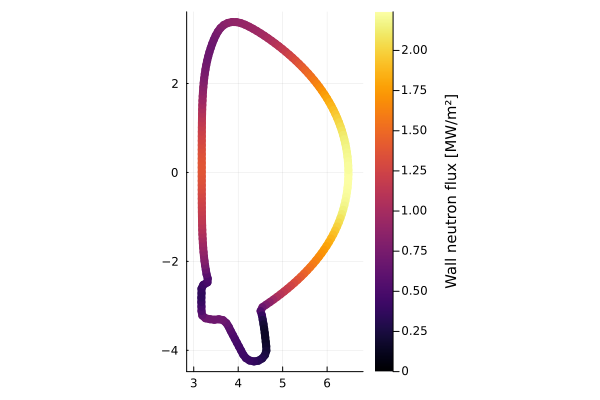

​


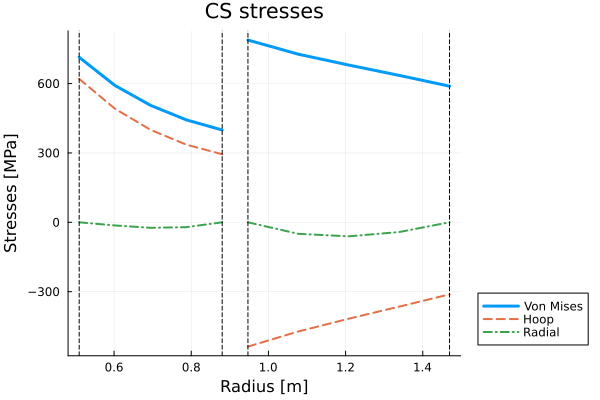

​


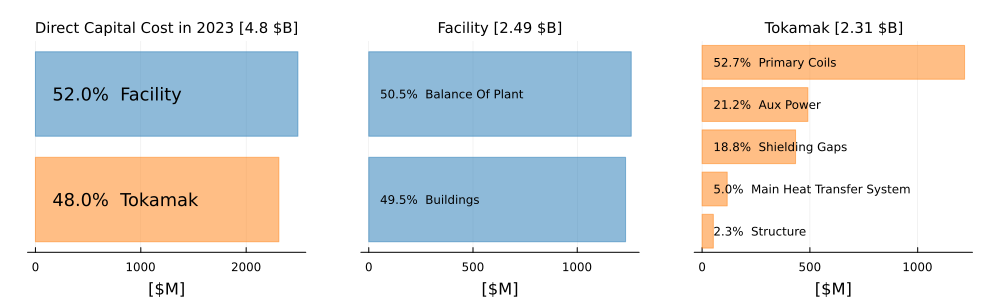

In [9]:
FUSE.digest(dd)

### See what are the possible optimization objectives and constraints

In [10]:
# FUSE comes with a library of objective and constraints functions
OFL = deepcopy(FUSE.ObjectiveFunctionsLibrary)
CFL = deepcopy(FUSE.ConstraintFunctionsLibrary)
println("== OBJECTIVE FUNCTIONS ==")
display(OFL)
println()
println("== CONSTRAINT FUNCTIONS ==")
display(CFL)

== OBJECTIVE FUNCTIONS ==


:max_power_electric_net => max_power_electric_net → Inf [MW]
:min_levelized_CoE => min_levelized_CoE → -Inf [$/kWh]
:max_fusion => max_fusion → Inf [MW]
:max_log10_flattop => max_log10_flattop → Inf [log₁₀(hours)]
:min_capital_cost => min_capital_cost → -Inf [$B]
:req_power_electric_net => req_power_electric_net → 0.0 [ΔMW]
:max_flattop => max_flattop → Inf [hours]
:min_βn => min_βn → -Inf []
:min_log10_levelized_CoE => min_log10_levelized_CoE → -Inf [log₁₀($/kW)]
:req_flattop => req_flattop → 0.0 [Δhours]



== CONSTRAINT FUNCTIONS ==


:required_power_electric_net => required_power_electric_net == 0.0 ± 0.01 [%]
:min_required_flattop => min_required_flattop > 0.0 [%]
:min_required_power_electric_net => min_required_power_electric_net > 0.0 [%]
:required_flattop => required_flattop == 0.0 ± 0.01 [%]
:zero_ohmic => zero_ohmic == 0.0 ± 0.1 [MA]


## Set the optimization objectives and constraints

In [11]:
ini.requirements

requirements{Float64}
├─ power_electric_net ➡ 2.0e8 [W] Target net electric power generated by the fusion power plant
├─ flattop_duration ➡ 43200.0 [s] Target duration of the flattop (use Inf for steady-state)
├─ log10_flattop_duration ➡ 3.5563025007672873 [log10(s)] Log10 value of the target duration of the flattop (use Inf for
│  steady-state). Preferred over `flattop_duration` for optimization studies.
└─ tritium_breeding_ratio ➡ 1.1 Target tritium breeding ratio of the whole plant


In [12]:
objective_functions = [OFL[:min_βn], OFL[:min_capital_cost], OFL[:max_log10_flattop]]
constraint_functions = [CFL[:min_required_power_electric_net]]#, CFL[:zero_ohmic]]
println("== OBJECTIVE FUNCTIONS ==")
display(objective_functions)
println()
println("== CONSTRAINT FUNCTIONS ==")
display(constraint_functions)

== OBJECTIVE FUNCTIONS ==


3-element Vector{FUSE.ObjectiveFunction}:
 min_βn → -Inf []
 min_capital_cost → -Inf [$B]
 max_log10_flattop → Inf [log₁₀(hours)]


== CONSTRAINT FUNCTIONS ==


1-element Vector{FUSE.ConstraintFunction}:
 min_required_power_electric_net > 0.0 [%]

### Setup and run optimization

In [13]:
# option to resume an optimization where it was left off
if false
    continue_results = results
else
    continue_results = missing
end

# define optimization parameters
# For real optimization studies the population size (N) and number of iterations should be bigger
# eg. N=100, iterations=25
optimization_parameters = Dict(
    :N => max(100, Int(floor((nprocs() - 1) / 2)) * 2), # even number
    :iterations => 25,
    :continue_results => continue_results,
    :save_folder => save_folder)

# run optimization
results = FUSE.workflow_multiobjective_optimization(ini, act, FUSE.ActorWholeFacility, objective_functions, constraint_functions; optimization_parameters...);


Running on 256 worker processes
== Actuators ==
ini.equilibrium.B0
- units: T
- description: Vacuum toroidal field at R0 [T]; Positive sign means anti-clockwise when viewing from above. The product R0B0 must be consistent with the b_tor_vacuum_r field of the tf IDS.
- value: 4.713171689711136
- base: 4.713171689711136
- default: missing
- opt: SimulationParameters.OptParameterRange{Float64}(4.713171689711136, 1.0, 20.0, Missing[])
ini.equilibrium.R0
- units: m
- description: Geometric genter of the plasma. NOTE: This also scales the radial build layers.
- value: 4.824432302041749
- base: 4.824432302041749
- default: missing
- opt: SimulationParameters.OptParameterRange{Float64}(4.824432302041749, 3.0, 10.0, Missing[])
ini.equilibrium.ip
- units: A
- description: Plasma current (toroidal component). Positive sign means anti-clockwise when viewed from above.
- value: 8.0e6
- base: 8.0e6
- default: missing
- opt: SimulationParameters.OptParameterRange{Float64}(8.0e6, 1.0e6, 2.2e7, Missing

Iteration  92%|█████████████████████████▊  |  ETA: 0:06:00 ( 3.00  m/it)

In [ ]:
results = FUSE.load_optimization(joinpath(save_folder, "optimization.bson"))
state=results.state
plot(results,[1,2],pareto=false)

LoadError: EOFError: read end of file

## Remember to always release computing resources!

In [1]:
for i in workers()
    rmprocs(i)
end

LoadError: UndefVarError: workers not defined